In [17]:
""" Shear flow data. """
from pathlib import Path
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


SHEARFLOW_GRID = {
    'reynolds': [1e4, 5e4, 1e5, 5e5],
    'schmidt': [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0],
    'n_shear': [2, 4],
    'n_blobs': [2, 3, 4, 5],
    'width': [0.25, 0.5, 1.0, 2.0, 4.0],
}

DATA_PATH = Path("/mnt/home/polymathic/ceph/the_well/2D/shear_flow/data/")

def filename(reynolds, schmidt):
    """ Hdf5 file name corresponding to one set of coefficients. """
    filename = f"Reynolds{reynolds:.1e}_Schmidt{schmidt:.1e}".replace('.','_').replace('-','m').replace('+','p')
    return filename + ".h5"

def read_data(reynolds, schmidt, n_shear, n_blobs, width):
    """ Read the data from the hdf5 file.
    
    Parameters
    ----------
    reynolds : float
        The Reynolds number (PDE coefficient).
    schmidt : float
        The Prandtl number (PDE coefficient).
    n_shear : int
        The number of shear layers (initial condition).
    n_blobs : int
        The number of velocity blobs on a shear (initial condition).
    width : float
        The width of the shear (initial condition).
    """
    filepath = DATA_PATH / filename(reynolds, schmidt)
    if (
        reynolds not in SHEARFLOW_GRID['reynolds'] or 
        schmidt not in SHEARFLOW_GRID['schmidt'] or 
        n_shear not in SHEARFLOW_GRID['n_shear'] or 
        n_blobs not in SHEARFLOW_GRID['n_blobs'] or
        width not in SHEARFLOW_GRID['width']
    ):
        raise ValueError(f"Invalid coefficients. The available coefficients are: {SHEARFLOW_GRID}")
    # find the right index in the batch
    idx_nshear = SHEARFLOW_GRID['n_shear'].index(n_shear)
    idx_nblobs = SHEARFLOW_GRID['n_blobs'].index(n_blobs)
    idx_width = SHEARFLOW_GRID['width'].index(width)
    idx = idx_nshear * len(SHEARFLOW_GRID['n_blobs']) * len(SHEARFLOW_GRID['width']) + idx_nblobs * len(SHEARFLOW_GRID['width']) + idx_width
    # load data
    hf = h5py.File(filepath, 'r')
    xt = np.stack([
        hf['tasks']['tracer'][idx,...],
        hf['tasks']['shear_velocity'][idx,:,0,...],
        hf['tasks']['vorticity'][idx,...],
        hf['tasks']['shear_velocity'][idx,:,1,...],
        hf['tasks']['pressure'][idx,...],
    ], axis=1)
    hf.close()
    return xt

def ploter_im(x):
    """ Plot a single frame of the data. """
    fig, axes = plt.subplots(1, 5, figsize=(12,14))
    def plot_one_axis(ax, y, vmax=None):
        if vmax is None:
            vmax = np.max(np.abs(y)) + 1e-6
        norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
        im = ax.imshow(y.T[::-1,:], cmap='RdBu_r', norm=norm)
        cbaxes = ax.inset_axes([0.01, 1.02, 0.99, 0.04])
        cbar = fig.colorbar(im, cax=cbaxes, orientation='horizontal')
        cbar.ax.tick_params(axis='x', direction='out', labeltop=True, labelbottom=False, bottom=False, top=True)
    axes[0].set_title('tracer')
    axes[1].set_title('shear')
    axes[2].set_title('vorticity')
    axes[3].set_title('velocity')
    axes[4].set_title('pressure')
    plot_one_axis(axes[0], x[0,:,:], vmax=0.7)
    plot_one_axis(axes[1], x[1,:,:], vmax=0.7)
    plot_one_axis(axes[2], x[2,:,:], vmax=5.5)
    plot_one_axis(axes[3], x[3,:,:], vmax=0.2)
    plot_one_axis(axes[4], x[4,:,:], vmax=0.1)
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    fig.subplots_adjust(wspace=0.05)

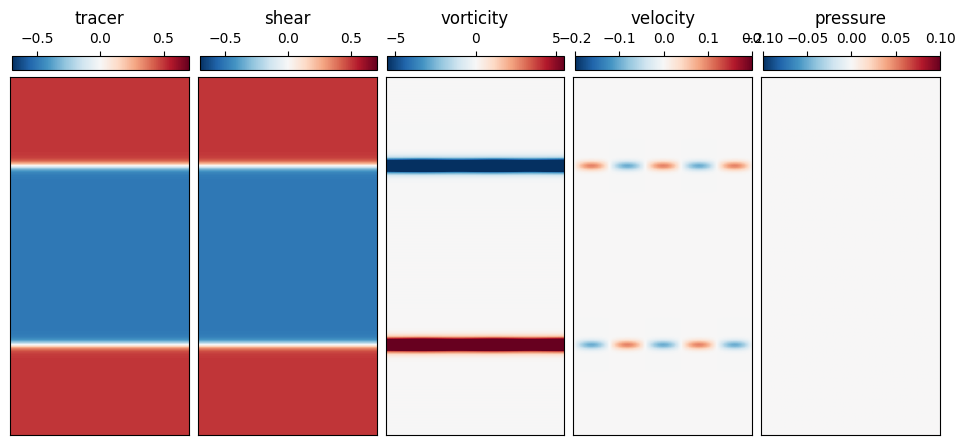

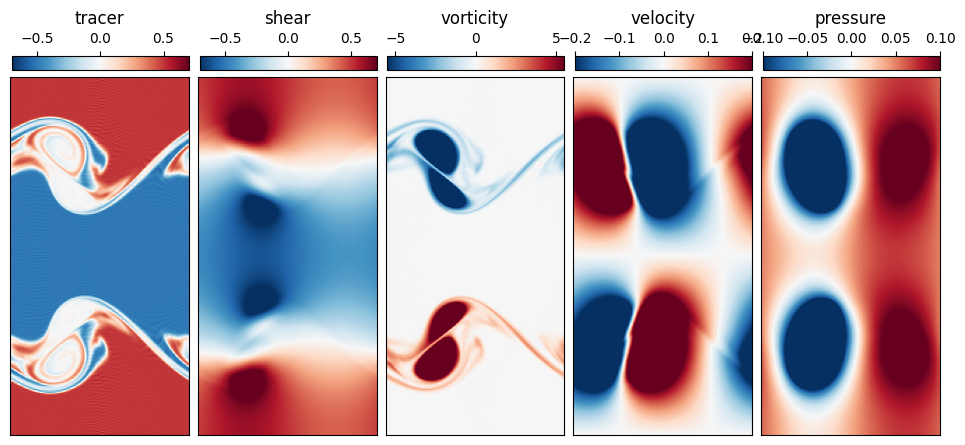

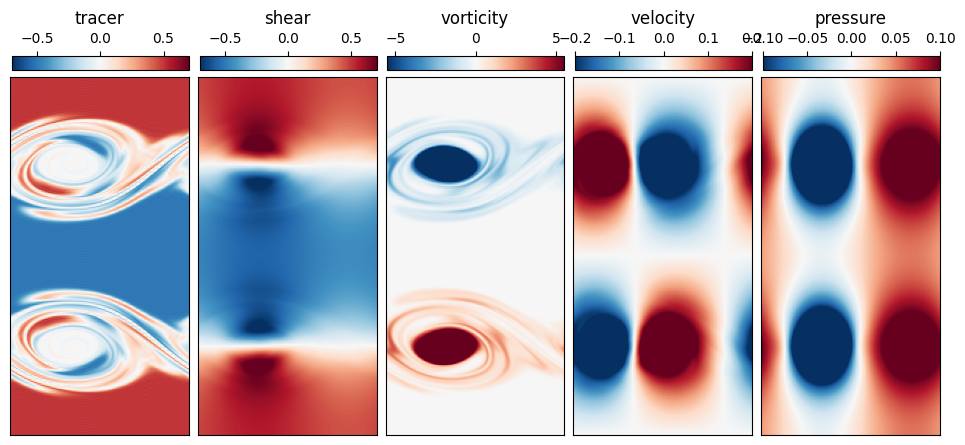

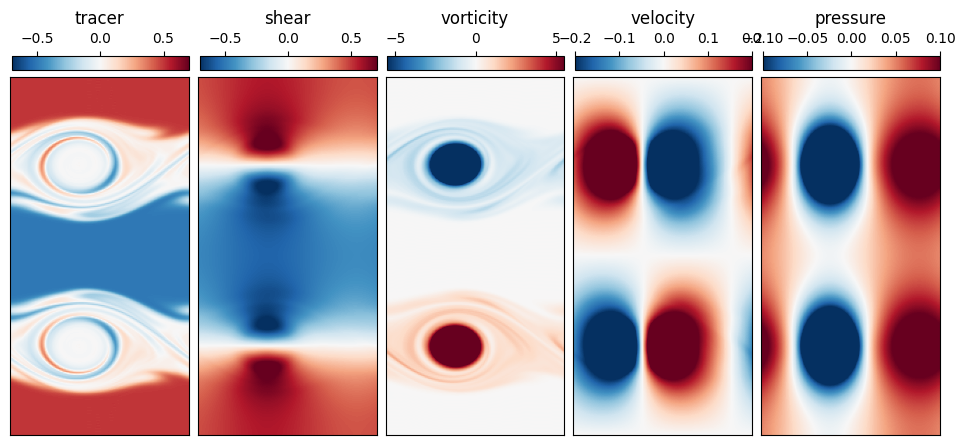

In [24]:
################################
reynolds = 5e4
schmidt = 1.0
n_shear = 2
n_blobs = 5
width = 0.25
################################

# load file
x = read_data(reynolds, schmidt, n_shear, n_blobs, width)
T, C, H, W = x.shape

# plot the data
for idx_time in range(0, T, T//4):
    ploter_im(x[idx_time, :, :, :])